Import all the needed modules

In [74]:
#!/usr/bin/python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
import multiprocessing
import time
from datetime import timedelta
from my_roc_auc3 import my_roc_auc
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

#Get total no of avaliable threads
nthreads = multiprocessing.cpu_count()

The scikit-learn version is 0.24.2.


Read in the coffea output as DF

In [76]:
from coffea.util import load
import numpy as np
import pandas as pd
import glob, os, json, argparse
years = ['2018','2017']
var_dict = [{}, {}, {}]
df = []
for year in years:
  print(f'Processing {year}')
  result = load(f"../results/{year}/makeDF/output.coffea")
  if isinstance(result,tuple):
      result = result[0]
  for varName in result:
    for i in range(3):
      if f'{i}jets' in varName:
        if varName.replace(f'_{i}jets','') in var_dict[i]:
          var_dict[i][varName.replace(f'_{i}jets','')] = np.append(var_dict[i][varName.replace(f'_{i}jets','')],result[varName].value)
        else:
          var_dict[i][varName.replace(f'_{i}jets','')] = result[varName].value
for i in range(3):
    df.append(pd.DataFrame(var_dict[i]))


Processing 2018
Processing 2017


In [146]:
njet = 0
data = df[njet] #pd.read_parquet('../results/csv4BDT/out_1jets.parquet')

print ('finish loading Dataframes')
print('Size of data: {}'.format(data.shape))
print('Number of events: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))
print ('\nList of features in dataset:')
for col in data.columns:
   print(col)

finish loading Dataframes
Size of data: (197544, 28)
Number of events: 197544
Number of columns: 28

List of features in dataset:
is2016preVFP
is2016postVFP
is2017
is2018
sample
label
weight
njets
e_m_Mass
met
eEta
mEta
mpt_Per_e_m_Mass
ept_Per_e_m_Mass
empt
emEta
DeltaEta_e_m
DeltaPhi_e_m
DeltaR_e_m
Rpt_0
e_met_mT
m_met_mT
e_met_mT_Per_e_m_Mass
m_met_mT_Per_e_m_Mass
pZeta85
pZeta15
pZeta
pZetaVis


Prepare training/testing samples

In [285]:
data_clean = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

data_cuts = data_clean[(data_clean['e_m_Mass']>115)&(data_clean['e_m_Mass']<135)&((data_clean['label']==1)|(data_clean['label']==0))]
data_vbf = data_cuts #[data_clean['isVBFcat']==0]
data_vbf.loc[:, ('absweight')] = data_vbf['weight'].abs()
#data_vbf.loc[:, ('label')] = data_vbf.label.astype('category')

# split data into X and y
X = data_vbf
Y = data_vbf['label']

# split data into train and test sets
seed = 123
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#Rescale signal weight to bkg weight
total_bkg_train_weights = X_train.loc[X_train['label'] == 0]['weight'].sum()
total_sig_train_weights = X_train.loc[X_train['label'] == 1]['weight'].sum()
sig_to_bkg_ratio = max(total_bkg_train_weights/total_sig_train_weights, total_sig_train_weights/total_bkg_train_weights)
print('Total Bkg Training weights', 'Total Sig Training weights')
print(total_bkg_train_weights, total_sig_train_weights)
print(sig_to_bkg_ratio)

/afs/hep.wisc.edu/home/kaho/miniconda3/envs/coffeaenv_conda/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Total Bkg Training weights Total Sig Training weights
4732.83485002014 7195.114947784434
1.5202548104449103


In [286]:
feature_names = ['e_met_mT', 'm_met_mT', 'mpt_Per_e_m_Mass', 'ept_Per_e_m_Mass', 'empt', 'met', 'DeltaR_e_m', 'emEta'] #, 'e_m_PZeta'
#feature_names = ['e_met_mT_Per_e_m_Mass', 'm_met_mT_Per_e_m_Mass', 'mpt_Per_e_m_Mass', 'ept_Per_e_m_Mass', 'empt', 'met', 'DeltaR_e_m', 'emEta', 'j1pt', 'DeltaR_j1_em', 'j1Eta'] #, 'R_pT'
#feature_names = ['mpt_Per_e_m_Mass', 'ept_Per_e_m_Mass', 'empt', 'met', 'DeltaR_e_m', 'emEta', 'j1pt', 'j1Eta', 'Rpt', 'j2pt', 'j2Eta', 'DeltaEta_j1_j2', 'pt_cen_Deltapt', 'j1_j2_mass', 'DeltaR_em_j1j2', 'Zeppenfeld_DeltaEta', 'DeltaPhi_j1_j2', 'DeltaR_j1_j2'] # 'Zeppenfeld_DeltaEta' 

/afs/hep.wisc.edu/home/kaho/miniconda3/envs/coffeaenv_conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:30:29] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Time spent on training 0:00:07.011470
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1.5202548104449103, seed=123, subsample=1,
              tree_method='exact', validate_param

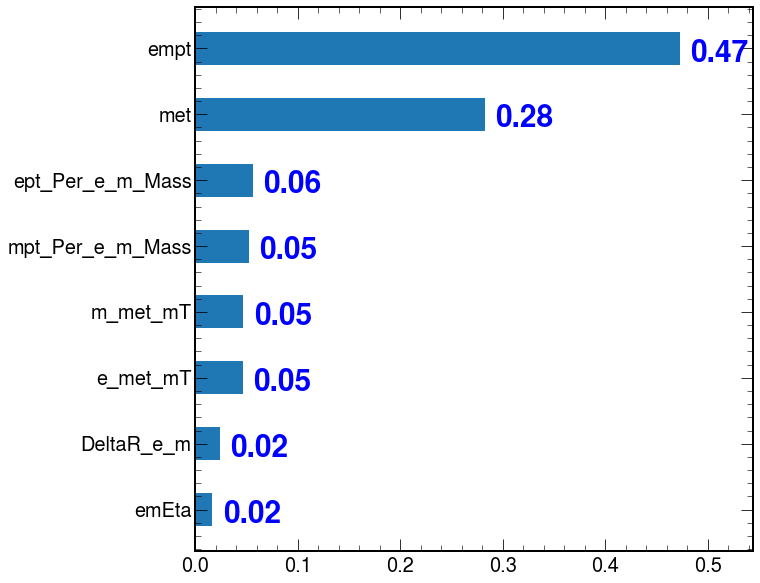

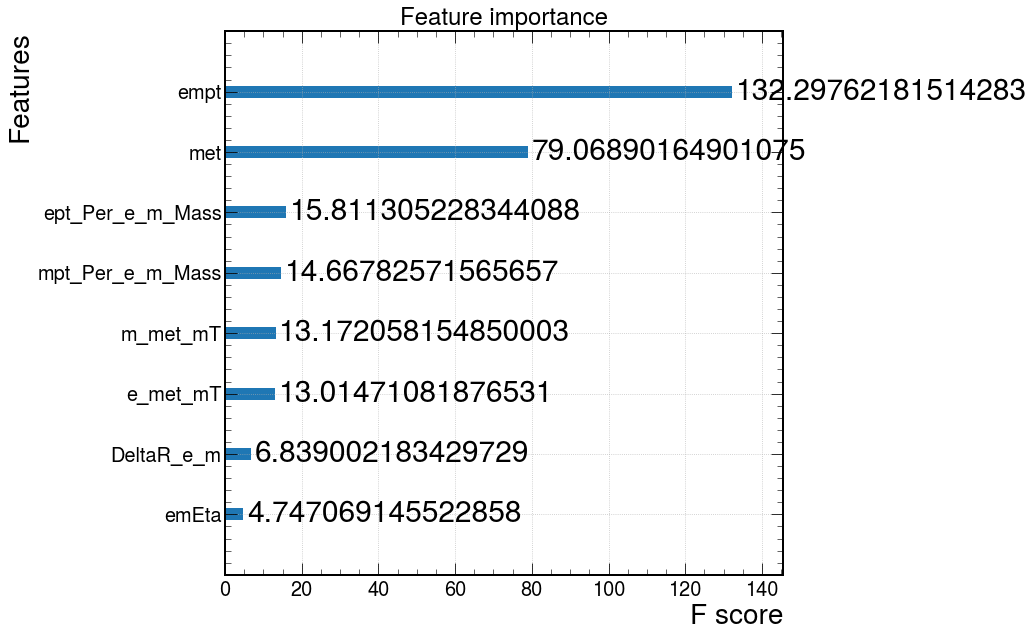

AUC of training set: 0.820540
AUC of testing set: 0.794505


In [293]:
# Train with the default model to select features
tic = time.time()
model = xgb.XGBClassifier(n_jobs=nthreads, scale_pos_weight=sig_to_bkg_ratio, early_stopping_rounds=10, learning_rate=0.1, max_depth=3, seed=123)
model.fit(X_train[feature_names], y_train, sample_weight=X_train['absweight'], eval_set = [(X_train[feature_names], y_train), (X_test[feature_names], y_test)], eval_metric='auc', sample_weight_eval_set = [X_train['absweight'], X_test['absweight']], verbose=False)
toc = time.time()
print("Time spent on training %s"%str(timedelta(seconds=toc - tic)))
print(model)

#Check the feature ranking
importances = model.feature_importances_
sorted_importance = [y for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
sorted_features = [x for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
plt.barh(range(len(sorted_importance)), sorted_importance, tick_label=sorted_features, height=0.5)
plt.xlim(0, max(sorted_importance)*1.15)
for i, v in enumerate(sorted_importance):
 plt.text(v+0.01, i-0.2, str(round(v,2)), color = 'blue', fontweight = 'bold')
plt.show()

xgb.plot_importance(model, importance_type="gain")
plt.show()

#Check also the auc
results = model.evals_result()
print ("AUC of training set: %f"%results['validation_0']['auc'][-1])
print ("AUC of testing set: %f"%results['validation_1']['auc'][-1])

#Modify features in the cell above accordingly and run again

In [294]:
X['mva'] = model.predict_proba(X[feature_names])[:,1]

/afs/hep.wisc.edu/home/kaho/miniconda3/envs/coffeaenv_conda/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_3414269/3455904527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['mva'] = model.predict_proba(X[feature_names])[:,1]


Overtraining test

/tmp/ipykernel_3414269/2832279640.py:84: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, 10**2)


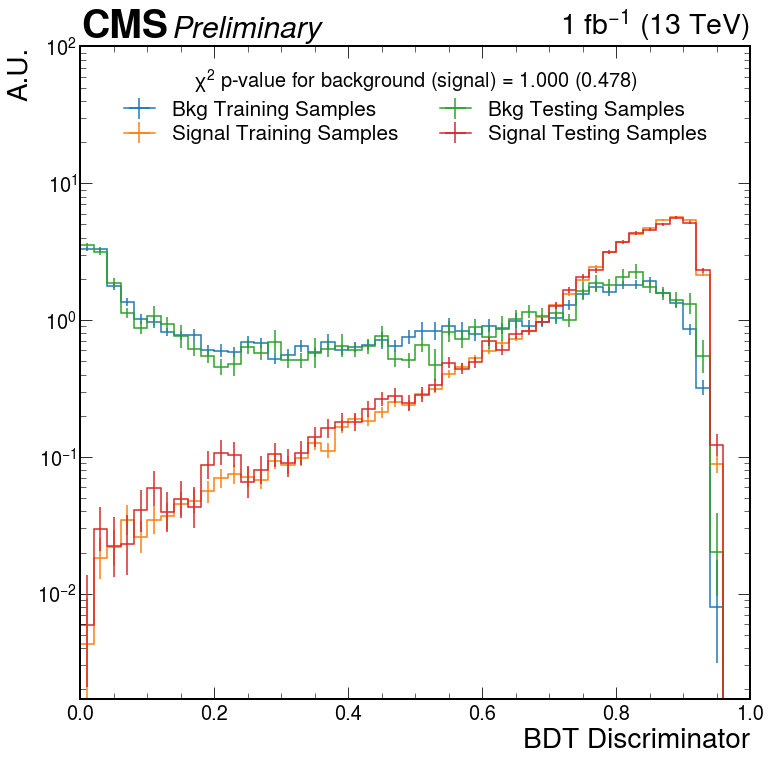

TFile**		Overtraining.root	
 TFile*		Overtraining.root	
  KEY: TH1D	Bkg Testing Samples;1	A.U.
  KEY: TH1D	Signal Testing Samples;1	A.U.
  KEY: TH1D	Bkg Training Samples;1	A.U.
  KEY: TH1D	Signal Training Samples;1	A.U.
Chi2 = 0.000000, Prob = 1, NDF = 47, igood = 3
Chi2 = 46.870757, Prob = 0.477869, NDF = 47, igood = 3


Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TH1D::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1D::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



In [295]:
df_test = X.loc[X_test.index, ['mva','label','weight']]
df_train = X.loc[X_train.index, ['mva','label','weight']]
df_test_bkg = df_test[df_test['label']==0]
df_train_bkg = df_train[df_train['label']==0]
df_test_signal = df_test[df_test['label']==1]
df_train_signal = df_train[df_train['label']==1]

from coffea import hist
h = hist.Hist('A.U.', hist.Bin('MVA', 'BDT Discriminator', 50, 0, 1), hist.Cat("sample", "sample"))
h.fill(MVA=df_test_bkg['mva'].to_numpy(), sample='Bkg Testing Samples', weight=df_test_bkg['weight'].to_numpy())
h.fill(MVA=df_test_signal['mva'].to_numpy(), sample='Signal Testing Samples', weight=df_test_signal['weight'].to_numpy())

h1 = hist.Hist('A.U.', hist.Bin('MVA', 'BDT Discriminator', 50, 0, 1), hist.Cat("sample", "sample"))
h1.fill(MVA=df_train_bkg['mva'].to_numpy(), sample='Bkg Training Samples', weight=df_train_bkg['weight'].to_numpy())
h1.fill(MVA=df_train_signal['mva'].to_numpy(), sample='Signal Training Samples', weight=df_train_signal['weight'].to_numpy())

import uproot3
root_file = uproot3.recreate("Overtraining.root")
for sample in ['Bkg Testing Samples', 'Signal Testing Samples']:
    root_file[sample] = hist.export1d(h.integrate('sample', sample))
for sample in ['Bkg Training Samples', 'Signal Training Samples']:
    root_file[sample] = hist.export1d(h1.integrate('sample', sample))

import ROOT as r
f_in = r.TFile('Overtraining.root')
f_in.ls()

h_test_bkg = f_in.Get('Bkg Testing Samples')
h_train_bkg = f_in.Get('Bkg Testing Samples')
h_test_sig = f_in.Get('Signal Testing Samples')
h_train_sig = f_in.Get('Signal Training Samples')

p_bkg = h_test_bkg.Chi2Test(h_train_bkg, 'WWP')
p_sig = h_test_sig.Chi2Test(h_train_sig, 'WWP')

import mplhep
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use(mplhep.style.CMS)

plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 24,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.title_fontsize': 20
})

error_opts = {
    'label': 'Stat. Unc.',
    'hatch': '///',
    'facecolor': 'none',
    'edgecolor': (0,0,0,.5),
    'linewidth': 0
}

fig = plt.figure(
        figsize=(12,12),
      )
ax = plt.axes()

# hist.plot1d(
#     h1,
#     ax=ax,
#     overlay='sample',
#     #density=True,
#     clear=False,
#     fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.4},
#     error_opts=error_opts,
# 

hist.plot1d(
    h1,
    ax=ax,
    density=True,
    clear=False,
)

hist.plot1d(h, ax=ax, density=True, clear=False)
ax.set_yscale('log')
ax.set_ylim(0, 10**2)
leg = ax.legend(fontsize='x-small', labelspacing=0.25, ncol=2, loc=9, title=f'$\chi^{2}$ p-value for background (signal) = {p_bkg:.3f} ({p_sig:.3f})')

lumi = mplhep.cms.label(ax=ax, lumi=1, label="Preliminary", data=1)

Check mass-independence of MVA quantiles

/afs/hep.wisc.edu/home/kaho/miniconda3/envs/coffeaenv_conda/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_3414269/3677850847.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bkg['mva'] = model.predict_proba(data_bkg[feature_names])[:,1]


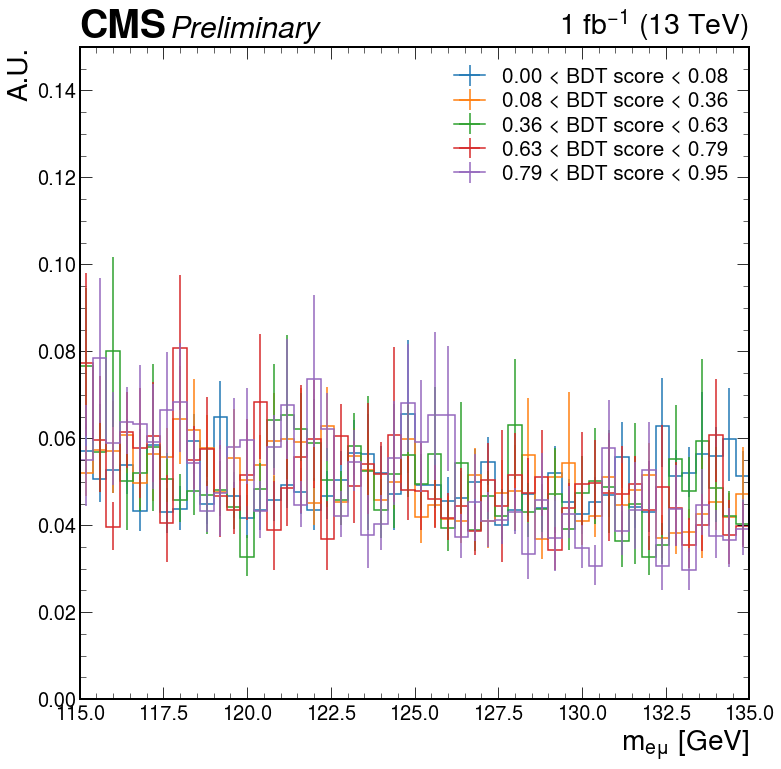

In [296]:
from coffea import hist

#Get the background
data_bkg = data_clean[data_clean['label']==0]
data_bkg['mva'] = model.predict_proba(data_bkg[feature_names])[:,1]

#Get 20% quantiles of the background
from statsmodels.stats.weightstats import DescrStatsW
wq = DescrStatsW(data=data_bkg['mva'], weights=data_bkg['weight'])
quantiles = wq.quantile(probs=np.array([0, 0.20, 0.40, 0.60, 0.80, 1]), return_pandas=False)

#Fill in sliced invariant mass according to MVA quantiles
h_quan = hist.Hist('A.U.', hist.Bin('e_m_Mass', '$m_{e\mu}$ [GeV]', 50, 115, 135), hist.Cat("sample", "sample"))
for i in range(len(quantiles)-1):
    quant25 = data_bkg[(data_bkg['mva']<quantiles[i+1])&(data_bkg['mva']>quantiles[i])]
    label = f'{quantiles[i]:.2f} < BDT score < {quantiles[i+1]:.2f}'
    h_quan.fill(e_m_Mass=quant25['e_m_Mass'].to_numpy(), sample=label, weight=quant25['weight'].to_numpy())

import mplhep
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use(mplhep.style.CMS)
plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 24,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.title_fontsize': 20
})

fig = plt.figure(
        figsize=(12,12),
      )

ax = hist.plot1d(h_quan, density=True)
ax.set_ylim(0, 0.15)
leg = ax.legend(fontsize='x-small', labelspacing=0.25)

lumi = mplhep.cms.label(ax=ax, lumi=1, label="Preliminary", data=1)

# plt.text(0.5, 15, f'$\chi^{2}$ p-value for background (signal) = {p_bkg:.3f} ({p_sig:.3f})', 
#          fontsize=20,
#          horizontalalignment='center',
#          verticalalignment='top')




Check Invariance of 120 and 130 Samples

/afs/hep.wisc.edu/home/kaho/miniconda3/envs/coffeaenv_conda/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/tmp/ipykernel_3414269/1126642289.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_125['mva'] = model.predict_proba(data_125[feature_names])[:,1]


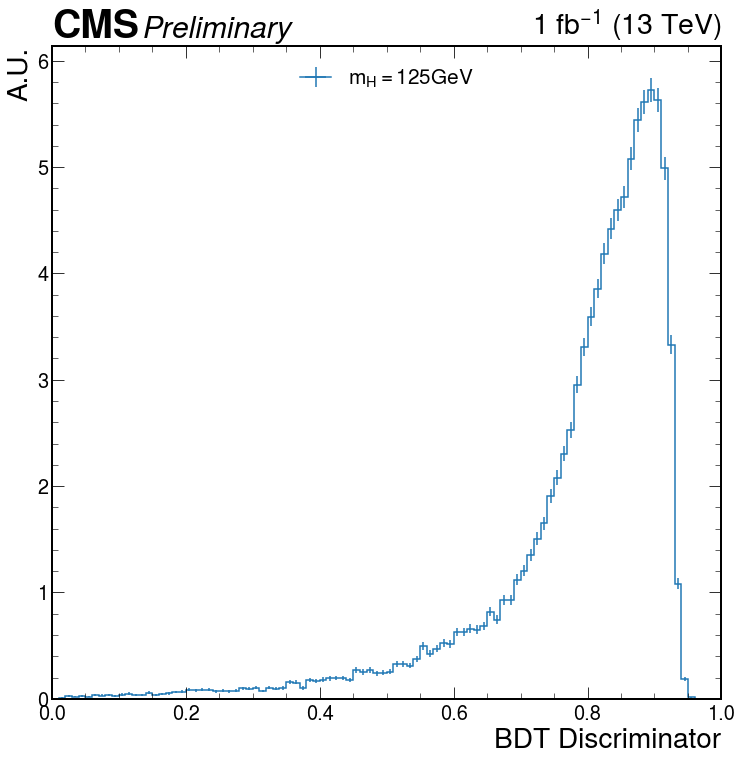

In [297]:
data_125 = data_clean[data_clean['label']==1]
# data_120 = data_clean[data_clean['label']==120]
# data_130 = data_clean[data_clean['label']==130]

data_125['mva'] = model.predict_proba(data_125[feature_names])[:,1]
# data_120['mva'] = model.predict_proba(data_120[feature_names])[:,1]
# data_130['mva'] = model.predict_proba(data_130[feature_names])[:,1]

h_mass = hist.Hist('A.U.', hist.Bin('MVA', 'BDT Discriminator', 100, 0, 1), hist.Cat("sample", "sample"))
h_mass.fill(MVA=data_125['mva'].to_numpy(), sample='$m_{H}=125$GeV', weight=data_125['weight'].to_numpy())
# h_mass.fill(MVA=data_130['mva'].to_numpy(), sample='$m_{H}=130$GeV', weight=data_130['weight'].to_numpy())
# h_mass.fill(MVA=data_120['mva'].to_numpy(), sample='$m_{H}=120$GeV', weight=data_120['weight'].to_numpy())

import mplhep
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use(mplhep.style.CMS)
plt.rcParams.update({
    'font.size': 30,
    'axes.titlesize': 24,
    'axes.labelsize': 28,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.title_fontsize': 20
})

fig = plt.figure(
        figsize=(12,12),
      )

ax = hist.plot1d(h_mass, density=True)
# ax.set_yscale('log')
# ax.set_ylim(0, 10**2)
leg = ax.legend(fontsize='x-small', labelspacing=0.25, ncol=2, loc=9)

lumi = mplhep.cms.label(ax=ax, lumi=1, label="Preliminary", data=1)

# plt.text(0.5, 15, f'$\chi^{2}$ p-value for background (signal) = {p_bkg:.3f} ({p_sig:.3f})', 
#          fontsize=20,
#          horizontalalignment='center',
#          verticalalignment='top')


In [53]:
# Hyperparameter optimization using RandomizedSearchCV

#Setup self-defined auc calculated with the U-test probability interpretation

score_params = {"weights": X_train['weight']}

my_auc = make_scorer(my_roc_auc,
                     needs_proba=True, 
                     **score_params)

# params={
#  "learning_rate"    : [ 0.10, 0.15, 0.20, 0.25, 0.30 ],
#  "max_depth"        : [ 3, 4, 5, 6, 8],
#  "min_child_weight" : [ 1, 3, 5, 7 ],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#  "colsample_bytree" : [ 0.6, 0.7, 0.8, 0.9, 1.0 ],
#  "subsample"        : [ 0.6, 0.7, 0.8, 0.9, 1.0 ],
#  "reg_lambda"       : [ 0.1, 1.0, 5.0, 10.0 ],            
#  "reg_alpha "       : [ 0, 0.1, 1.0, 5.0 ],    
#  "n_estimators"     : [ 80, 100, 120, 150 ],
#  "scale_pos_weight" : [sig_to_bkg_ratio],   
# }

# a more conservative set for 0-jet events
params=[
{
 "learning_rate"    : [ 0.20 ],
 "max_depth"        : [ 2 ],
 "subsample"        : [ 0.5, 0.6 ],
 "reg_lambda"       : [ 10.0, 20.0 ],  
 "reg_alpha "       : [ 10.0, 20.0 ],
 "n_estimators"     : [ 120, 140 ],
 "scale_pos_weight" : [sig_to_bkg_ratio]   
}
,
    
{
 "learning_rate"    : [ 0.25 ],
 "max_depth"        : [ 2 ],
 "subsample"        : [ 0.5, 0.6 ],
 "reg_lambda"       : [ 20.0, 30.0 ],  
 "reg_alpha "       : [ 20.0, 30.0 ],
 "n_estimators"     : [ 120, 140 ],
 "scale_pos_weight" : [sig_to_bkg_ratio]   
}
,
    
{
 "learning_rate"    : [ 0.25 ] ,
 "max_depth"        : [ 3 ],
 "subsample"        : [ 0.5, 0.6 ],
 "reg_lambda"       : [ 20.0, 30.0 ],  
 "reg_alpha "       : [ 20.0, 30.0 ],
 "n_estimators"     : [ 80, 100 ],
 "scale_pos_weight" : [sig_to_bkg_ratio]   
}
    
,

{
 "learning_rate"    : [ 0.30 ] ,
 "max_depth"        : [ 3 ],
 "subsample"        : [ 0.5, 0.6 ],
 "reg_lambda"       : [ 30.0 ],  
 "reg_alpha "       : [ 30.0 ],
 "n_estimators"     : [ 80, 100 ],
 "scale_pos_weight" : [sig_to_bkg_ratio]   
}
    
,
    
{
 "learning_rate"    : [ 0.20, 0.25 ] ,
 "max_depth"        : [ 4 ],
 "subsample"        : [ 0.5, 0.6 ],
 "reg_lambda"       : [ 30.0 ],  
 "reg_alpha "       : [ 30.0 ],
 "n_estimators"     : [ 60, 80 ],
 "scale_pos_weight" : [sig_to_bkg_ratio]   
}

]
print params
model = xgb.XGBClassifier(n_jobs=nthreads, seed=123)
# use random_state=123 for reproducibility
random_search=GridSearchCV(model,param_grid=params, scoring=my_auc,n_jobs=nthreads,cv=3, verbose=3)
#random_search=RandomizedSearchCV(model,param_distributions=params,n_iter=10,scoring=my_auc,n_jobs=nthreads,cv=3, verbose=3)
tic = time.time()
random_search.fit(X_train[feature_names], y_train, sample_weight=X_train['weight'])
toc = time.time()
print "Time spent on hyperparameter optimization %s"%str(timedelta(seconds=toc - tic))

[{'scale_pos_weight': [1.4643960793015485], 'learning_rate': [0.2], 'reg_alpha ': [10.0, 20.0], 'n_estimators': [120, 140], 'subsample': [0.5, 0.6], 'reg_lambda': [10.0, 20.0], 'max_depth': [2]}, {'scale_pos_weight': [1.4643960793015485], 'learning_rate': [0.25], 'reg_alpha ': [20.0, 30.0], 'n_estimators': [120, 140], 'subsample': [0.5, 0.6], 'reg_lambda': [20.0, 30.0], 'max_depth': [2]}, {'scale_pos_weight': [1.4643960793015485], 'learning_rate': [0.25], 'reg_alpha ': [20.0, 30.0], 'n_estimators': [80, 100], 'subsample': [0.5, 0.6], 'reg_lambda': [20.0, 30.0], 'max_depth': [3]}, {'scale_pos_weight': [1.4643960793015485], 'learning_rate': [0.3], 'reg_alpha ': [30.0], 'n_estimators': [80, 100], 'subsample': [0.5, 0.6], 'reg_lambda': [30.0], 'max_depth': [3]}, {'scale_pos_weight': [1.4643960793015485], 'learning_rate': [0.2, 0.25], 'reg_alpha ': [30.0], 'n_estimators': [60, 80], 'subsample': [0.5, 0.6], 'reg_lambda': [30.0], 'max_depth': [4]}]
Fitting 3 folds for each of 60 candidates, t

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.20.3-nmpfii2/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed: 17.9min
[Parallel(n_jobs=24)]: Done 180 out of 180 | elapsed: 36.7min finished


Time spent on hyperparameter optimization 0:37:19.879179


In [54]:
random_search.cv_results_

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.20.3-nmpfii2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.20.3-nmpfii2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-scikit-learn/0.20.3-nmpfii2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by d

{'mean_fit_time': array([ 75.05222726,  94.14709473, 111.47608829, 122.2682244 ,
        126.46650092, 175.71395334, 212.98633766, 235.32948033,
        265.53004297, 254.9572049 , 261.97513   , 263.56766661,
        232.23752546, 212.24572905, 222.96649639, 211.17968829,
        180.18426498, 156.78237669, 173.17228842, 147.42744366,
        161.95260628, 222.07015069, 218.80297438, 243.21379924,
        261.213082  , 258.78173629, 276.71754909, 279.05023305,
        242.87006672, 245.05637296, 240.65478039, 247.65560031,
        190.58787696, 202.74773033, 202.73168961, 216.1958069 ,
        229.254644  , 253.7029833 , 260.53535533, 205.65585041,
        265.31992141, 258.76058229, 283.59429328, 309.29582739,
        274.11249169, 262.2753586 , 266.26846695, 256.40840125,
        225.34203561, 224.48333232, 254.65684605, 238.67067607,
        212.01159064, 201.62991397, 277.34322627, 283.63284787,
        215.55982534, 241.48888334, 198.94639158, 157.68205031]),
 'mean_score_time': a

In [59]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=10, learning_rate=0.25,
       max_delta_step=0, max_depth=4, min_child_weight=7, missing=None,
       n_estimators=100, n_jobs=24, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_alpha =10.0, reg_lambda=20.0,
       scale_pos_weight=1.4643960793015485, seed=123, silent=True,
       subsample=0.7)

In [18]:
# Bayesian Optimization 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

score_params = {"weights": X_train['weight']}

#Setup self-defined auc calculated with the U-test probability interpretation
my_auc = make_scorer(my_roc_auc,
                     needs_proba=True, 
                     **score_params)

space={ 'max_depth': hp.quniform('max_depth', 3, 5, 1),
        'gamma': hp.quniform ('gamma', 0, 10, 1),
        'reg_alpha' : hp.quniform('reg_alpha', 0, 20, 1),
        'reg_lambda' : hp.quniform('reg_lambda', 0, 20, 1),
        'n_estimators': hp.quniform("n_estimators", 100, 175, 1),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.8, 0.01),
        'subsample': hp.quniform('subsample', 0.6, 0.8, 0.01),
        'learning_rate': hp.quniform('learning_rate', 0.1, 0.3, 0.01),        
       }

def hyperparameter_tuning(space):
    model = xgb.XGBClassifier(n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']), 
                              gamma=space['gamma'], reg_alpha=space['reg_alpha'], reg_lambda=space['reg_lambda'],
                              colsample_bytree=space['colsample_bytree'], subsample=space['subsample'],
                              learning_rate=space['learning_rate'],
                              scale_pos_weight=sig_to_bkg_ratio, n_jobs=24, early_stopping_rounds=10)
    auc = cross_val_score(estimator=model, X=X_train[feature_names], y=y_train, scoring=my_auc, n_jobs=nthreads, cv=3)
    CrossValMean = auc.mean()
    return {'loss': 1-CrossValMean, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print (best)

100%|██████████| 50/50 [1:10:47<00:00, 84.78s/it, best loss: 0.0965711873937]
{'reg_alpha': 6.0, 'colsample_bytree': 0.61, 'learning_rate': 0.21, 'n_estimators': 158.0, 'subsample': 0.73, 'reg_lambda': 10.0, 'max_depth': 5.0, 'gamma': 0.0}


In [24]:
print trials.trials

[{'refresh_time': datetime.datetime(2021, 7, 14, 19, 29, 45, 67000), 'book_time': datetime.datetime(2021, 7, 14, 19, 28, 54, 761000), 'misc': {'tid': 0, 'idxs': {'reg_alpha': [0], 'colsample_bytree': [0], 'learning_rate': [0], 'n_estimators': [0], 'subsample': [0], 'reg_lambda': [0], 'max_depth': [0], 'gamma': [0]}, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'vals': {'reg_alpha': [12.0], 'colsample_bytree': [0.72], 'learning_rate': [0.17], 'n_estimators': [124.0], 'subsample': [0.65], 'reg_lambda': [10.0], 'max_depth': [3.0], 'gamma': [1.0]}, 'workdir': None}, 'state': 2, 'tid': 0, 'exp_key': None, 'version': 0, 'result': {'status': 'ok', 'loss': 0.09886820563143628, 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.72, early_stopping_rounds=10, gamma=1.0,
       learning_rate=0.17, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=124, n_jobs=24,
       nthread=None, objective='binary:logist

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.61, early_stopping_rounds=10, gamma=0.0,
       learning_rate=0.21, max_delta_step=0, max_depth=5, maximize=True,
       min_child_weight=1, missing=None, n_estimators=158, n_jobs=24,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=6.0, reg_lambda=10.0, scale_pos_weight=3.151886734544248,
       seed=123, silent=True, subsample=0.73)
Time spent on training 0:01:21.666210
AUC of training set: 0.925023
AUC of testing set: 0.912580


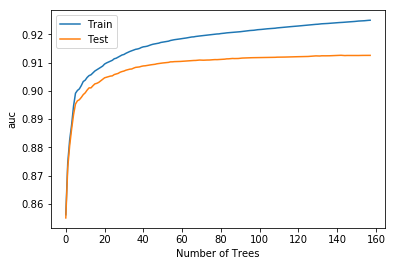

In [20]:
# Retrain with the best model
# Use seed=123 for reproducibility
tic = time.time()
#0 jets
# model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.8, gamma=10, learning_rate=0.25,
#        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
#        n_estimators=150, n_jobs=24, nthread=None,
#        objective='binary:logistic', random_state=0,
#        reg_alpha =5.0, reg_lambda=10.0,
#        scale_pos_weight=1.4643960793015485, seed=123, silent=True,
#        subsample=0.7)
#1 jets
# model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.8, gamma=5, learning_rate=0.28,
#        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
#        n_estimators=175, n_jobs=24, nthread=None,
#        objective='binary:logistic', random_state=0,
#        reg_alpha = 0.0, reg_lambda=1.0,
#        scale_pos_weight=sig_to_bkg_ratio, seed=123, silent=True,
#        subsample=0.7)

# model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.8, gamma=4, learning_rate=0.1,
#        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
#        n_estimators=150, n_jobs=24, nthread=None,random_state=0,
#        reg_alpha = 5.0, reg_lambda=10.0, objective='binary:logistic',
#        scale_pos_weight=sig_to_bkg_ratio, seed=123, silent=True,
#        subsample=0.7)
import math
params = {'reg_alpha': 6.0, 'colsample_bytree': 0.61, 'learning_rate': 0.21, 'n_estimators': 158, 'subsample': 0.73, 'reg_lambda': 10.0, 'max_depth': 5, 'gamma': 0.0}
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', n_jobs=24, nthread=None, random_state=0,
        objective='binary:logistic', scale_pos_weight=sig_to_bkg_ratio, early_stopping_rounds = 10, maximize = True, seed=123, silent=True)
model.set_params(**params)
# model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.8, gamma=4, learning_rate=0.1,
#        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
#        n_estimators=150, n_jobs=24, nthread=None,random_state=0,
#        reg_alpha = 5.0, reg_lambda=10.0, objective='binary:logistic',
#        scale_pos_weight=5*sig_to_bkg_ratio, seed=123, silent=True,
#        subsample=0.8)
print model
model.fit(X_train[feature_names], y_train, sample_weight=X_train['weight'], eval_set = [(X_train[feature_names], y_train), (X_test[feature_names], y_test)], eval_metric='auc', sample_weight_eval_set = [X_train['weight'], X_test['weight']], verbose=False)
toc = time.time()
print "Time spent on training %s"%str(timedelta(seconds=toc - tic))

#Get AUC of final model for both training and testing set to avoid overtraining
results = model.evals_result()
print "AUC of training set: %f"%results['validation_0']['auc'][-1]
print "AUC of testing set: %f"%results['validation_1']['auc'][-1]

epochs = len(results['validation_0']['auc'])
x_axis = range(epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc')
plt.xlabel('Number of Trees')
plt.show()

# Alternative way to get AUC
# train = xgb.DMatrix(data=X_train[feature_names],label=X_train.label.cat.codes,
#                    feature_names=feature_names, weight=X_train['weight'])
# test = xgb.DMatrix(data=X_test[feature_names],label=X_test.label.cat.codes,
#                    feature_names=feature_names, weight=X_test['weight'])
# booster = model.get_booster()
# print(booster.eval(test))
# print(booster.eval(train))

#sklearn auc does not work on negative weights
#y_pred = model.predict_proba(X_test[feature_names])
#print roc_auc_score(y_test, y_pred[:,1], sample_weight=X_test['weight'])

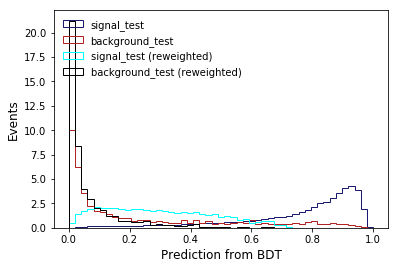

In [17]:
# plot signal and background separately
predictions_sig_test = model.predict_proba(X_test.loc[X_test['label'] == 1][feature_names])
predictions_bkg_test = model.predict_proba(X_test.loc[X_test['label'] == 0][feature_names])
predictions_sig_test2 = model2.predict_proba(X_test.loc[X_test['label'] == 1][feature_names])
predictions_bkg_test2 = model2.predict_proba(X_test.loc[X_test['label'] == 0][feature_names])
plt.figure();
weights_sig_test = X_test.loc[X_test['label'] == 1]['weight']
weights_bkg_test = X_test.loc[X_test['label'] == 0]['weight']
weights_sig_train = X_train.loc[X_train['label'] == 1]['weight']
weights_bkg_train = X_train.loc[X_train['label'] == 0]['weight']
plt.hist(predictions_sig_test2[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal_test', weights=weights_sig_test);
plt.hist(predictions_bkg_test2[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background_test', weights=weights_bkg_test);
plt.hist(predictions_sig_test[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='cyan',label='signal_test (reweighted)', weights=weights_sig_test);
plt.hist(predictions_bkg_test[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='black',label='background_test (reweighted)', weights=weights_bkg_test);
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False, loc = 2);

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in divide
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.10.0/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in divide


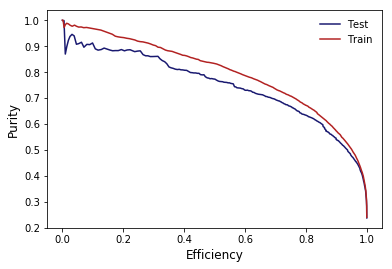

In [21]:
#Additional overtraining test
cuts = np.linspace(0,1,500);
#testing set
nsignal_test = np.zeros(len(cuts));
nbackground_test = np.zeros(len(cuts));
#Get predictions from trained mode
predictions_sig_test = model.predict_proba(X_test.loc[X_test['label'] == 1][feature_names])
predictions_bkg_test = model.predict_proba(X_test.loc[X_test['label'] == 0][feature_names])

predictions_sig_train = model.predict_proba(X_train.loc[X_train['label'] == 1][feature_names])
predictions_bkg_train = model.predict_proba(X_train.loc[X_train['label'] == 0][feature_names])

weights_sig_test = X_test.loc[X_test['label'] == 1]['weight'].to_numpy()
weights_bkg_test = X_test.loc[X_test['label'] == 0]['weight'].to_numpy()
weights_sig_train = X_train.loc[X_train['label'] == 1]['weight'].to_numpy()
weights_bkg_train = X_train.loc[X_train['label'] == 0]['weight'].to_numpy()

# weights_sig_test[weights_sig_test<0] = 0
# weights_bkg_test[weights_bkg_test<0] = 0
# weights_sig_train[weights_sig_train<0] = 0
# weights_bkg_train[weights_bkg_train<0] = 0

for i,cut in enumerate(cuts):
    sig_loc = np.where(predictions_sig_test[:,1] > cut)[0]
    bkg_loc = np.where(predictions_bkg_test[:,1] > cut)[0]
    nsignal_test[i] = weights_sig_test[sig_loc].sum()
    nbackground_test[i] = weights_bkg_test[bkg_loc].sum()
# unweighted
#     nsignal_test[i] = len(np.where(predictions_sig_test[:,1] > cut)[0]);
#     nbackground_test[i] = len(np.where(predictions_bkg_test[:,1] > cut)[0]);

#training set
nsignal_train = np.zeros(len(cuts));
nbackground_train = np.zeros(len(cuts));
for i,cut in enumerate(cuts):
    sig_loc = np.where(predictions_sig_train[:,1] > cut)[0]
    bkg_loc = np.where(predictions_bkg_train[:,1] > cut)[0]
    nsignal_train[i] = weights_sig_train[sig_loc].sum()
    nbackground_train[i] = weights_bkg_train[bkg_loc].sum()
# unweighted
#     nsignal_train[i] = len(np.where(predictions_sig_train[:,1] > cut)[0]);
#     nbackground_train[i] = len(np.where(predictions_bkg_train[:,1] > cut)[0]);
# plot efficiency vs. purity (ROC curve)
plt.figure();
purity_test = nsignal_test/(nsignal_test + nbackground_test)
purity_train = nsignal_train/(nsignal_train + nbackground_train)
purity_test[np.isnan(purity_test)] = 1
purity_train[np.isnan(purity_train)] = 1

plt.plot(nsignal_test/weights_sig_test.sum(), purity_test,'-',color='midnightblue', label='Test');
plt.plot(nsignal_train/weights_sig_train.sum(), purity_train,'-',color='firebrick', label='Train');

# unweighted
# plt.plot(nsignal_test/len(X_test[X_test.label == 1]), nsignal_test/(nsignal_test + nbackground_test),'-',color='midnightblue', label='Test');
# plt.plot(nsignal_train/len(X_train[X_train.label == 1]),nsignal_train/(nsignal_train + nbackground_train),'-',color='firebrick', label='Train');
# make the plot readable
plt.xlabel('Efficiency',fontsize=12);
plt.ylabel('Purity',fontsize=12);
plt.legend(frameon=False);

In [ ]:
#Check the feature ranking again with the best model

importances = model.feature_importances_
sorted_importance = [y for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
sorted_features = [x for y, x in sorted(zip(importances, feature_names), key=lambda pair: pair[0])]
plt.barh(range(len(sorted_importance)), sorted_importance, tick_label=sorted_features, height=0.5)
plt.xlim(0, max(sorted_importance)*1.15)
for i, v in enumerate(sorted_importance):
 plt.text(v+0.01, i-0.2, str(round(v,2)), color = 'blue', fontweight = 'bold')
plt.show()

xgb.plot_importance(model, importance_type="gain")
plt.show()

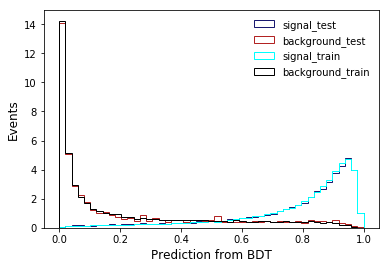

In [22]:
# plot signal and background separately
plt.figure();
plt.hist(predictions_sig_test[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal_test', weights=weights_sig_test);
plt.hist(predictions_bkg_test[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background_test', weights=weights_bkg_test);
plt.hist(predictions_sig_train[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='cyan',label='signal_train', weights=weights_sig_train);
plt.hist(predictions_bkg_train[:,1],density=True,bins=np.linspace(0,1,50),
         histtype='step',color='black',label='background_train', weights=weights_bkg_train);
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

In [12]:
#Save model if everything looks good
model_out_file = "model_GG_2jets.json"
model.save_model(model_out_file)

In [14]:
#Load and predict from model
model_load = xgb.XGBClassifier()
model_load.load_model(model_out_file)
predictions = model_load.predict_proba(X_test[feature_names])
print predictions

[[0.11725003 0.88275   ]
 [0.97172993 0.02827005]
 [0.9947172  0.00528282]
 ...
 [0.05969727 0.9403027 ]
 [0.91208166 0.08791832]
 [0.97825897 0.02174105]]


ModuleNotFoundError: No module named 'ROOT'